# Dependencies

In [11]:
import qutip as qp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import qiskit
from qiskit.circuit.library import HamiltonianGate, UnitaryGate, RYGate, RZGate
from qiskit import Aer, transpile, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error
from qiskit.providers.fake_provider import *
from quantuminspire.qiskit import QI
from quantuminspire.credentials import enable_account

# Hamiltonian

The Hamiltonian describing the collective oscillation of 2-flavored neutrinos in the flavor basis is:
$$
H = \sum_{i} \frac{\delta m^2}{4E}(\sin 2\theta X_i - \cos 2\theta Z_i) + \frac{G_F N_e}{\sqrt 2 V}Z_i + \sum_{j < k} \frac{\sqrt 2 G_F}{V}(1 - \cos\phi_{jk}) (X_j X_k + Y_jY_k + Z_jZ_k)
$$
where $V$ is the volume of the system, $N_e$ is the number of background electrons, $\theta$ the mixing angle and $\phi_{ij}$ the propagation angle between neutrino $i$ and $j$
This Hamiltonian can be rewritten in terms of pairs of neutrinos using the fact that $\sum_{i=1}^N a_i = \sum_{i<j}^N \frac{a_i+a_j}{N-1}$. Suppose there are $N$ neutrinos then
$$
H = \sum_{i < j} \frac{\delta m^2}{4E(N-1)}(\sin 2\theta X_i - \cos 2\theta Z_i) + \frac{G_F N_e}{\sqrt 2 V (N-1)}Z_i +  \frac{\delta m^2}{4E(N-1)}(\sin 2\theta X_j - \cos 2\theta Z_j) + \frac{G_F N_e}{\sqrt 2 V(N-1)}Z_j + \frac{\sqrt 2 G_F}{V}(1 - \cos\phi_{ij}) (X_i X_j + Y_iY_j + Z_iZ_j)
$$

## Explanation

To understand the form of the Hamiltonian we shall start by looking at the Hamiltonian of a single neutrino in a vacuum. This neutrino's mass is an observable with eigenstates $|m_1\rangle, |m_2\rangle$. These mass eigenstates are also the energy eigenstates, which means the Hamiltonian in the mass basis is $\frac{\delta m^2}{4E}Z$ (up to a constant offset).

Just as electrons posses spin, neutrinos posses flavor. The eigenstates of flavor are $|\nu_e\rangle$ and $|\nu_\mu\rangle$ (electron and muon neutrinos). For simulation purposes we will encode them as $|\nu_e\rangle = |0\rangle$ and $|\nu_\mu\rangle = |1\rangle$.

Converting a vector in flavor basis into a vector in mass basis is done by multiplying with the matrix:
$$
\begin{bmatrix}
\cos 2\theta & -\sin 2\theta\\
\sin 2\theta & \cos 2\theta
\end{bmatrix}
$$
$\theta$ is called the mixing angle because it describes how mass and flavor mix.

The vacuum Hamiltonian in flavor basis is hence (up to a global phase)
$$
\frac{\delta m^2}{4E} \begin{bmatrix}
-\cos 2\theta & \sin 2\theta\\
\sin 2\theta & \cos 2\theta
\end{bmatrix} = \frac{\delta m^2}{4E}(\sin 2\theta X - \cos 2\theta Z)
$$

The presence of electrons scatters electron neutrino, thus changing the energy for electron neutrinos. This is reflected in the Hamiltonian by adding $\frac{\sqrt 2 G_F N_e}{ V} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}$. The Hamiltonian of a neutrino in matter is thus $\frac{\delta m^2}{4E}(\sin 2\theta X - \cos 2\theta Z) + \frac{G_F N_e}{\sqrt 2 V}Z$, once again up to a constant.

Now for a pair of neutrinos, we will describe their interaction/scattering similar to the Heisenberg model, as $J(X_1X_2+Y_1Y_2+Z_1Z_2)$. The strength of interaction, $J$, should be propotional to the cosine/angular distance between the momenta of the neutrinos. Indeed, $J = \frac{\sqrt 2 G_F}{V}(1 - \cos\phi_{ij})$ where $\phi$, the propagation angle, is the angle between the momentum vectors of the two neutrinos.

And so the Hamiltonian for $N$ neutrinos is the sum Hamiltonian for each neutrino plus the interaction between every pair.

## Units

We will let $\hbar = 1$. Using the relation $E=\frac{h}{t}$, a unit of time can be specified using the inverse of energy. Following [literature](https://arxiv.org/pdf/2207.03189v1.pdf), let's define energy $\mu = \frac{\sqrt{2}G_F N}{V}$. Let $\mu$ be our unit of energy (set $\mu=1$) and thus $\mu^{-1}$ be the unit of time. The Hamiltonian then simplifies to
$$
H = \sum_{i} \kappa (\sin 2\theta X_i - \cos 2\theta Z_i) + \frac{\rho_e}{2}Z_i + \sum_{j, k}\frac{(1 - \cos\phi_{jk})}{N} (X_j X_k + Y_jY_k + Z_jZ_k) = \sum_i \underline b \cdot \underline \sigma_i + \sum_{j<k} \frac{(1 - \cos\phi_{jk})}{N} \underline \sigma_j \cdot \underline \sigma_k
$$

Where $\rho_e = \frac {N_e} {N}$, this is the density of electrons relative to neutrinos, and $\kappa = \frac{\delta m ^2 V}{4\sqrt 2 E G_F N}$, meaning $\kappa N$ is the relative strength between one-body energy and interaction energy. For compactness, $\underline b = (\kappa \sin 2\theta, 0, \frac{\rho_e}{2}-\kappa \cos 2\theta)$ and $\underline \sigma = (X,Y,Z)$. In pairwise form, $H = \sum_{i<j} \frac{\underline b}{N-1} \cdot \underline (\sigma_i + \sigma_j) + \frac{(1 - \cos\phi_{ij})}{N} \underline \sigma_i \cdot \underline \sigma_j$

## Implementation

In [12]:
class Hamiltonian:
    def __init__(self, N, kappa, theta, rho, Phi):
        """
        N: Number of neutrinos
        kappa: Relative strength of one body energy divided by the number of neutrinos
        theta: Mixing angle
        rho: Electron relative density
        Phi: Propagation angle matrix, Phi[i,j] for i<j is the propagation angle between neutrinos i and j.
        """
        assert Phi.shape == (N,N)
        self.N = N
        self.kappa = kappa
        self.theta = theta
        self.rho = rho
        self.Phi = Phi
        self.b1 = self.kappa * np.sin(2*self.theta)
        self.b2 = 0
        self.b3 = self.rho/2 - self.kappa * np.cos(2*self.theta)

    def pauliX(i,N):
        return qp.tensor([qp.sigmax() if j == i else qp.identity(2) for j in range(N)])

    def pauliY(i,N):
        return qp.tensor([qp.sigmay() if j == i else qp.identity(2) for j in range(N)])
    
    def pauliZ(i,N):
        return qp.tensor([qp.sigmaz() if j == i else qp.identity(2) for j in range(N)])
        
    def toQObj(self):
        """Return Hamiltonian as qutip QObj"""        
        H = qp.tensor([0 * qp.identity(2) for i in range(self.N)]) # initial H to zero matrix

        for i in range(self.N):
            X = Hamiltonian.pauliX(i, self.N)
            Y = Hamiltonian.pauliY(i, self.N)
            Z = Hamiltonian.pauliZ(i, self.N)
            H += self.b1*X + self.b2*Y + self.b3*Z
        
        for i in range(self.N):
            for j in range(i+1, self.N):
                phi = self.Phi[i,j]
                Xi = Hamiltonian.pauliX(i, self.N)
                Yi = Hamiltonian.pauliY(i, self.N)
                Zi = Hamiltonian.pauliZ(i, self.N)
                Xj = Hamiltonian.pauliX(j, self.N)
                Yj = Hamiltonian.pauliY(j, self.N)
                Zj = Hamiltonian.pauliZ(j, self.N)
                H += (1-np.cos(phi))/self.N * (Xi * Xj + Yi * Yj + Zi * Zj)

        return H

    def pairQObj(self, i, j):
        """Return Hamiltonian for neutrino i and j as qutip QObj"""
        assert i < j, "expect i < j"
        
        X0 = Hamiltonian.pauliX(0, 2)
        Y0 = Hamiltonian.pauliY(0, 2)
        Z0 = Hamiltonian.pauliZ(0, 2)
        X1 = Hamiltonian.pauliX(1, 2)
        Y1 = Hamiltonian.pauliY(1, 2)
        Z1 = Hamiltonian.pauliZ(1, 2)
        H = (self.b1 * (X0 + X1) + self.b2 * (Y0 + Y1) + self.b3 * (Z0 + Z1))/(self.N-1) + (1 - np.cos(self.Phi[i,j]))/self.N * (X0*X1+Y0*Y1+Z0*Z1)
        return H

    def interactionQObj(self, i, j):
        """Return the interaction term between neutrinos i and j as qutip QObj"""
        X0 = Hamiltonian.pauliX(0, 2)
        Y0 = Hamiltonian.pauliY(0, 2)
        Z0 = Hamiltonian.pauliZ(0, 2)
        X1 = Hamiltonian.pauliX(1, 2)
        Y1 = Hamiltonian.pauliY(1, 2)
        Z1 = Hamiltonian.pauliZ(1, 2)
    
        H = (1 - np.cos(self.Phi[i,j]))/self.N * (X0 * X1 + Y0 * Y1 + Z0 * Z1)
        return H

# Experiments

Modelling the flavor dynamics of neutrinos require the evolution operator $U$. Encoding $U$ as a quantum circuit using state-of-the-art algorithms require number of gates expoential to the neutrino counts. Furthermore, unlike the Hubbard model, the collective neutrino oscillation Hamiltonian has an interaction term between every pair of neutrinos; for $N$ neutrinos the number of terms is $O(N^2)$. Having so many gates render the circuit prone to errors. One solution is to use an approximate evolution operator $\tilde U=U+O(t^k)$ that is shorter to encode. Because the error of $\tilde U$ grows with time, $|\psi(t)\rangle$ is usually computed as $\tilde U(dt)^k|\psi(0)\rangle$ where $dt$ is the size of each time step.

The approximate circuit's depth should be much lesser than the exact circuit's depth, so it is less affected by quantum error. This also implies that the approximate circuit should have low error for a large step size because $\tilde U^k$ is encoded as the concatenation of $k$ circuits implementing $\tilde U$, thus with a larger step size, $k$ can be smaller, producing a shallower circuit.

In this project, we investigate the error of different approximation schemes across a range of step sizes. The error is quantified as the difference in inversion probability from the exact value calculated from classical simulations; inversion probability is the probability at time $dt$ that the neutrino differs from its initial flavor.

## Backend

In [13]:
T1s = np.ones(4) * 100 # nanoseconds
T2s = 2 * T1s
single_gate_time = 1 
double_gate_time = 1
single_gates = ['rx','ry','rz','id']
noise = NoiseModel()
for i in range(N):
    for s in single_gates:
        error = thermal_relaxation_error(T1s[i], T2s[i], single_gate_time)
        noise.add_quantum_error(error, s, [i])
    
for i in range(N):
    for j in range(N):
        if i != j:
            error = thermal_relaxation_error(T1s[i], T2s[i], double_gate_time).expand(thermal_relaxation_error(T1s[j], T2s[j], double_gate_time))
            noise.add_quantum_error(error, 'cz', [i,j])

In [14]:
backend = FakeMumbaiV2() # AerSimulator(noise_model=noise)

## Initial conditions

Based on exisitng literature, we set $\theta = 0.195$, $\phi_{ij} = \arccos(0.9)\frac{|i-j|}{N-1}$ and $\kappa = \frac 1 N$ so one-body and interaction terms have comparable contribution to total energy. We will set $\rho_e = 0.2$ so matter effect is present but not dominating. Due to hardware limitations, we will only model 4 neutrinos. The 2 flavors are encoded as $|0\rangle$ and $|1\rangle$. The initial condition is $|0011\rangle$.

In [7]:
N = 4
kappa = 1/N
theta = 0.195
rho = 0.2
Phi = np.arccos(0.9)/(N-1) * np.array([[abs(i-j) for i in range(N)] for j in range(N)])
Ham = Hamiltonian(N, kappa, theta, rho, Phi)

initial_flavors = [0,0,1,1]

t_start = 0
t_end = 30
steps = 300
shots = 5000

times = np.linspace(t_start, t_end, num=steps)

## Classical simulation

In [8]:
classical_steps = steps # adjust if steps needs to be small for hardware reasons
classical_times = np.linspace(t_start, t_end, num=classical_steps)
initial_state = qp.tensor([qp.basis(2,i) for i in initial_flavors])
result = qp.mesolve(Ham.toQObj(), initial_state, classical_times, [])
density_matrices = [qp.ket2dm(state) for state in result.states]
classical_probabilities = np.zeros((N,classical_steps))
for t_idx, dm in enumerate(density_matrices):
    for i in range(N):
        classical_probabilities[i, t_idx] = dm.ptrace(i).diag()[1] if initial_flavors[i] == 0 else dm.ptrace(i).diag()[0]

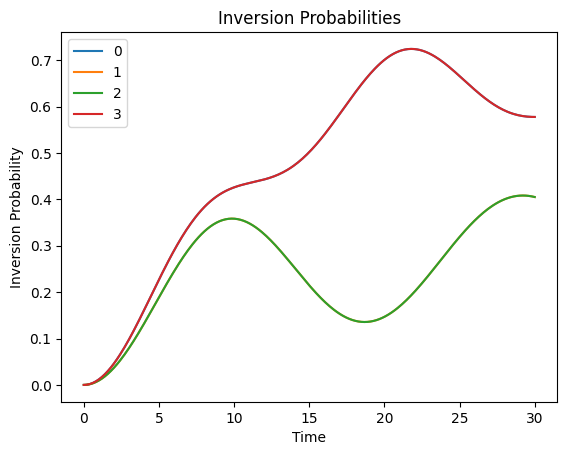

In [9]:
# Plot the probability curve for each qubit on the same graph
for qubit in range(N):
    plt.plot(classical_times, classical_probabilities[qubit], label=f'{qubit}')
    plt.xlabel('Time')
    plt.ylabel('Inversion Probability')
    plt.title(f'Inversion Probabilities')
plt.legend()
plt.show()

## Unapproximated Quantum Simulation

In [15]:
def closest_unitary(A):
    """ Calculate the unitary matrix U that is closest with respect to the
        operator norm distance to the general matrix A.

        Return U as a numpy matrix.
    """
    V, __, Wh = sp.linalg.svd(A)
    U = np.matrix(V.dot(Wh))
    return U

unapproximated_probabilities = np.zeros((N, steps))
depths = []

for t_idx, t in enumerate(times):
    U = closest_unitary(sp.linalg.expm(-1j*t*Ham.toQObj().data.toarray()))
    U = UnitaryGate(U, label='FullHamiltonian')
    circuit = QuantumCircuit(N)

    circuit.initialize("".join(map(str, reversed(initial_flavors)))) # NOTE: initialize has to be at the start, before appending gates
    circuit.append(U, range(N))
    circuit.measure_all()
    circ = transpile(circuit, backend)
    

    depths.append(circ.depth())
        
    result = qiskit.execute(circ, backend, shots=shots).result()
    counts = result.get_counts()
    
    bit_frequencies = [0 for i in range(N)] # A counter for how many times each qubit flips
    outcomes = []
    
  
    for bitstring, frequency in counts.items():
        bit_list = list(map(int, bitstring))
        bit_list = np.array(list(reversed(bit_list))) # Reverse because little-endian?
        for i in range(frequency):
            inversions = (bit_list + initial_flavors) % 2 # 1 if inverted, 0 if not
            outcomes.append(inversions)
    outcomes = np.array(outcomes)
    assert outcomes.shape == (shots, N)
    
    probability = outcomes.mean(axis=0)
    assert len(probability) == N
    unapproximated_probabilities[:, t_idx] = probability

    

QiskitError: 'TwoQubitWeylDecomposition: failed to diagonalize M2. Please report this at https://github.com/Qiskit/qiskit-terra/issues/4159. Input: [[(-0.3166677946222087+0.6194496281262211j), (0.004814556709790897-0.017169026523570968j), (0.10789674301630137+0.06892241968031748j), (-0.6955019840822046-0.124782585664439j)], [(-0.31642193986841527+0.6189686994117892j), (-0.004818297543336942+0.017182366580537567j), (0.10781297407024838+0.06886890964574352j), (0.6960423779270423+0.1248795397240041j)], [(0.11386348060616423+0.058240270396209416j), (-0.2441976675132367+0.6638784624558328j), (-0.37424136284486503+0.585577346134408j), (-0.017266010025963466-0.004530329418667164j)], [(0.11404598091840848+0.05826889484592327j), (0.24356466175647304-0.6630782281686121j), (-0.37449111876994806+0.5865495757485927j), (0.01724437962524737+0.004516361930252234j)]]'

In [ ]:
for qubit in range(N):
    plt.plot(classical_times, classical_probabilities[qubit], label=f'Classical Sim')
    plt.plot(times, unapproximated_probabilities[qubit], label=f'Quantum Sim')

    plt.xlabel('Time')
    plt.ylabel('Inversion Probability')
    plt.title(f'Inversion Probabilities of Neutrino {qubit+1}')
    plt.legend()
    plt.show()
print(f"Circuit Depth: {max(depths)}")

## Approximations

We will investigate trotter decomposition and fractal decomposition (also known as Suzuki's method) for they are standard techniques of approximating operator expoentials.

### Trotter decomposition (single)

Trotter decomposition approximates the expoential of an operator sum as the product of operator exponeitals, accuracy up to the 1st order. Its principle that $e^{x\sum_i H_i} = I + x\sum_i H_i + O(x^2) = \prod_i e^{x H_i} + O(x^2)$. For our Hamiltonian, it can be expressed as a sum of Hamiltonians between pairs of neutrinos. It follows then $e^{-itH} \approx \prod_{i < j}e^{-itH_{ij}}$ where $H_{ij} = \frac{\underline b}{N-1} \cdot \underline (\sigma_i + \sigma_j) + \frac{(1 - \cos\phi_{ij})}{N} \underline \sigma_i \cdot \underline \sigma_j$.

In [10]:
single_trotter_probabilities = np.zeros((N, steps))
depths = []

for t_idx, t in enumerate(times):
    circuit = QuantumCircuit(N)
    circuit.initialize("".join(map(str, reversed(initial_flavors))))
    for i in range(N):
        for j in range(i+1,N):
            H = HamiltonianGate(Ham.pairQObj(i,j).data.toarray(), t, label=f'PairHamiltonian {i},{j}')
            circuit.append(H, [i,j])

    circuit.measure_all()
        
    circ = transpile(circuit, backend)
    
    depths.append(circ.depth())
        
    result = qiskit.execute(circ, backend, shots=shots).result()
    counts = result.get_counts()
    
    bit_frequencies = [0 for i in range(N)] # A counter for how many times each qubit flips
    outcomes = []
    
    for bitstring, frequency in counts.items():
        bit_list = list(map(int, bitstring))
        bit_list = np.array(list(reversed(bit_list))) # Reverse because little-endian?
        for i in range(frequency):
            inversions = (bit_list + initial_flavors) % 2 # 1 if inverted, 0 if not
            outcomes.append(inversions)
    outcomes = np.array(outcomes)
    assert outcomes.shape == (shots, N)
    
    probability = outcomes.mean(axis=0)
    assert len(probability) == N
    single_trotter_probabilities[:, t_idx] = probability


RuntimeInvalidStateError: 'Unable to retrieve result for job cpszxy7d7p30008x47hg. Job was cancelled.'

In [ ]:
fig, axs = plt.subplots(N, 2, figsize=(12, 12))
for qubit in range(N):
    axs[qubit, 0].plot(classical_times, classical_probabilities[qubit], label=f'Classical Sim')
    axs[qubit, 0].plot(times, single_trotter_probabilities[qubit], label=f'Quantum Sim')
    error = np.abs(classical_probabilities[qubit] - single_trotter_probabilities[qubit])
    axs[qubit, 1].plot(times, error, label=f'Error')

    axs[qubit, 0].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit, 0].set_ylabel('Inversion Probability')
    axs[qubit, 0].set_title(f'Inversion Probability of neutrino {qubit+1}')
    axs[qubit, 0].legend()
    axs[qubit, 0].grid(True)
    
    axs[qubit, 1].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit, 1].set_ylabel('Absolute Error')
    axs[qubit, 1].set_title(f'Simulation Error of neutrino {qubit+1}')
    axs[qubit, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"Circuit Depth: {max(depths)}")

### Trotter decomposition (double)

Trotter decomposition can alternatively be used separate one-body terms and interaction terms in the Hamiltonian. $e^{itH}\approx e^{-itH_1}e^{-itH_2}$ where $H_1 = \sum_i \underline b \cdot \underline \sigma_i$ and $ H_2 = \sum_{i<j} \frac{(1 - \cos\phi_{ij})}{N} \underline \sigma_i \cdot \underline \sigma_j$. Terms in the one-body Hamiltonian commute, so $e^{-itH_1} = \prod_i e^{-it\underline b \cdot \underline \sigma_i}$. As for the interaction Hamiltonian, Trotter decomposition is applied again, $e^{-itH_2} \approx \prod_{i<j} e^{-it\frac{(1 - \cos\phi_{ij})}{N} \underline \sigma_i \cdot \underline \sigma_j}$.

Since the one body Hamiltonian is a tensor product of single neutrino Hamiltonian, so it translates to single qubit gates applied in parallel. Thus it suffices to consider one such gate. The Hamiltonian for a single neutrino takes the form of $aX+bZ$. Diagonalizing this gives:
$\begin{bmatrix} \frac{a}{\sqrt{a^2+(c-b)^2}} & \frac{b-c}{\sqrt{a^2+(b-c)^2}} \\ \frac{c-b}{\sqrt{a^2+(c-b)^2}} & \frac{a}{\sqrt{a^2+(b-c)^2}} \end{bmatrix} \begin{bmatrix} c & 0\\ 0 & -c \end{bmatrix} \begin{bmatrix} \frac{a}{\sqrt{a^2+(c-b)^2}} & \frac{c-b}{\sqrt{a^2+(c-b)^2}} \\ \frac{b-c}{\sqrt{a^2+(b-c)^2}} & \frac{a}{\sqrt{a^2+(b-c)^2}} \end{bmatrix}$
where $c=\sqrt{a^2+b^2}$.

The evolution operator $e^{-it(aX+bZ)}$ must be $ \begin{bmatrix} \frac{a}{\sqrt{a^2+(c-b)^2}} & \frac{b-c}{\sqrt{a^2+(b-c)^2}} \\ \frac{c-b}{\sqrt{a^2+(c-b)^2}} & \frac{a}{\sqrt{a^2+(b-c)^2}} \end{bmatrix} \begin{bmatrix} e^{-itc} & 0\\ 0 & e^{itc} \end{bmatrix} \begin{bmatrix} \frac{a}{\sqrt{a^2+(c-b)^2}} & \frac{c-b}{\sqrt{a^2+(c-b)^2}} \\ \frac{b-c}{\sqrt{a^2+(b-c)^2}} & \frac{a}{\sqrt{a^2+(b-c)^2}} \end{bmatrix} $

Now translating this into gates, given that 
$R_z(\phi) = e^{-i \frac{\phi}{2} Z}$ and $R_y(\theta) = \begin{bmatrix} \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2}) \\  \sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2}) \end{bmatrix}$, this means $e^{-it(aX+bZ)}=R_y(\theta)R_z(\phi)R_y(-\theta)$ where $\phi = 2tc$ and $\theta = 2\arctan(\frac{c-b}{a})$.

In [101]:
def OneBodyGate(t, a,b):    
    c = np.sqrt(a**2+b**2)
    Ry_angle = 2*np.arctan2(c-b,a)
    Rz_angle = 2*t*c
    return RYGate(-Ry_angle), RZGate(Rz_angle), RYGate(Ry_angle)

In [102]:
double_trotter_probabilities = np.zeros((N, steps))
depths = []

for t_idx, t in enumerate(times): 
    circuit = QuantumCircuit(N)
    circuit.initialize("".join(map(str, reversed(initial_flavors))))
    mRy, Rz, Ry = OneBodyGate(t, Ham.b1, Ham.b3)
    for i in range(N):
        circuit.append(mRy, [i])
        circuit.append(Rz, [i])
        circuit.append(Ry, [i])
        
    for i in range(N):
        for j in range(i+1,N):
            H = HamiltonianGate(Ham.interactionQObj(i,j).data.toarray(), t, label=f'TwoBodyHamiltonian {i},{j}')
            circuit.append(H, [i,j])
            
    circuit.measure_all()
        
    circ = transpile(circuit, backend)
    
    depths.append(circ.depth())
        
    result = qiskit.execute(circ, backend, shots=shots).result()
    counts = result.get_counts()
    
    bit_frequencies = [0 for i in range(N)] # A counter for how many times each qubit flips
    outcomes = []
    
    for bitstring, frequency in counts.items():
        bit_list = list(map(int, bitstring))
        bit_list = np.array(list(reversed(bit_list))) # Reverse because little-endian?
        for i in range(frequency):
            inversions = (bit_list + initial_flavors) % 2 # 1 if inverted, 0 if not
            outcomes.append(inversions)
    outcomes = np.array(outcomes)
    assert outcomes.shape == (shots, N)
    
    probability = outcomes.mean(axis=0)
    assert len(probability) == N
    double_trotter_probabilities[:, t_idx] = probability

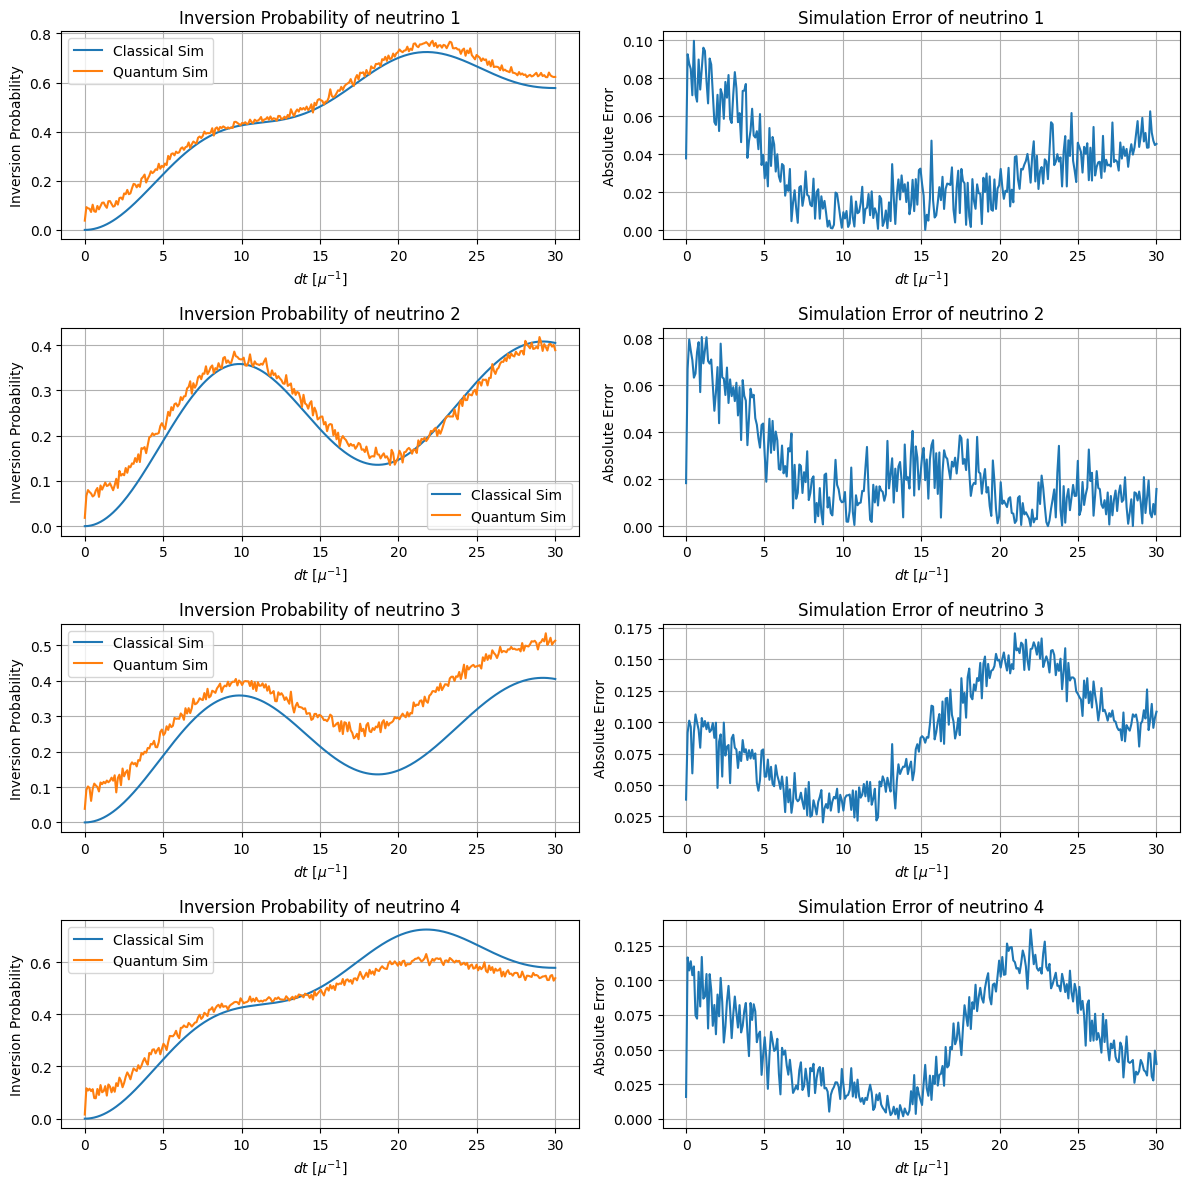

Circuit Depth: 123


In [103]:
fig, axs = plt.subplots(N, 2, figsize=(12, 12))
for qubit in range(N):
    axs[qubit, 0].plot(classical_times, classical_probabilities[qubit], label=f'Classical Sim')
    axs[qubit, 0].plot(times, double_trotter_probabilities[qubit], label=f'Quantum Sim')
    error = np.abs(classical_probabilities[qubit] - double_trotter_probabilities[qubit])
    axs[qubit, 1].plot(times, error, label=f'Error')

    axs[qubit, 0].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit, 0].set_ylabel('Inversion Probability')
    axs[qubit, 0].set_title(f'Inversion Probability of neutrino {qubit+1}')
    axs[qubit, 0].legend()
    axs[qubit, 0].grid(True)
    
    axs[qubit, 1].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit, 1].set_ylabel('Absolute Error')
    axs[qubit, 1].set_title(f'Simulation Error of neutrino {qubit+1}')
    axs[qubit, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"Circuit Depth: {max(depths)}")

### Fractal decomposition (order 2)

It can be shown using induction that $e^{x\sum_{i=1}^n H_i} = I + x\sum_i H_i + \frac{x^2}{2}\sum_{j,k} H_iH_k + O(x^3) = \prod_{i=1}^n e^{\frac x 2 H_i}\prod_{i=n}^1 e^{\frac x 2 H_i} + O(x^3)$. Hence we can approximate $e^{-itH}$ as $(\prod_{i=1}^n \prod_{j>i}^n e^{-itH_{ij}})(\prod_{i=n}^1 \prod_{j>i}^{i+1} e^{-itH_{ij}})$

In [104]:
fractal_probabilities = np.zeros((N, steps))
depths = []

for t_idx, t in enumerate(times):
    circuit = QuantumCircuit(N)
    circuit.initialize("".join(map(str, reversed(initial_flavors))))
    
    for i in range(N):
        for j in range(i+1,N):
            if not (i == N-2 and j == N-1):
                H = HamiltonianGate(Ham.pairQObj(i,j).data.toarray(), t/2, label=f'PairHamiltonian {i},{j}')
                circuit.append(H, [i,j])
                  
    H = HamiltonianGate(Ham.pairQObj(N-2,N-1).data.toarray(), t, label=f'PairHamiltonian {N-2},{N-1}')
    circuit.append(H, [N-2,N-1])  
            
    for i in reversed(range(N)):
        for j in reversed(range(i+1,N)):
            if not (i == N-2 and j == N-1):
                H = HamiltonianGate(Ham.pairQObj(i,j).data.toarray(), t/2, label=f'PairHamiltonian {i},{j}')
                circuit.append(H, [i,j])
        
    circuit.measure_all()
        
    circ = transpile(circuit, backend)
    
    depths.append(circ.depth())
        
    result = qiskit.execute(circ, backend, shots=shots).result()
    counts = result.get_counts()
    
    bit_frequencies = [0 for i in range(N)] # A counter for how many times each qubit flips
    outcomes = []
    
    for bitstring, frequency in counts.items():
        bit_list = list(map(int, bitstring))
        bit_list = np.array(list(reversed(bit_list))) # Reverse because little-endian?
        for i in range(frequency):
            inversions = (bit_list + initial_flavors) % 2 # 1 if inverted, 0 if not
            outcomes.append(inversions)
    outcomes = np.array(outcomes)
    assert outcomes.shape == (shots, N)
    
    probability = outcomes.mean(axis=0)
    assert len(probability) == N
    
    fractal_probabilities[:, t_idx] = probability

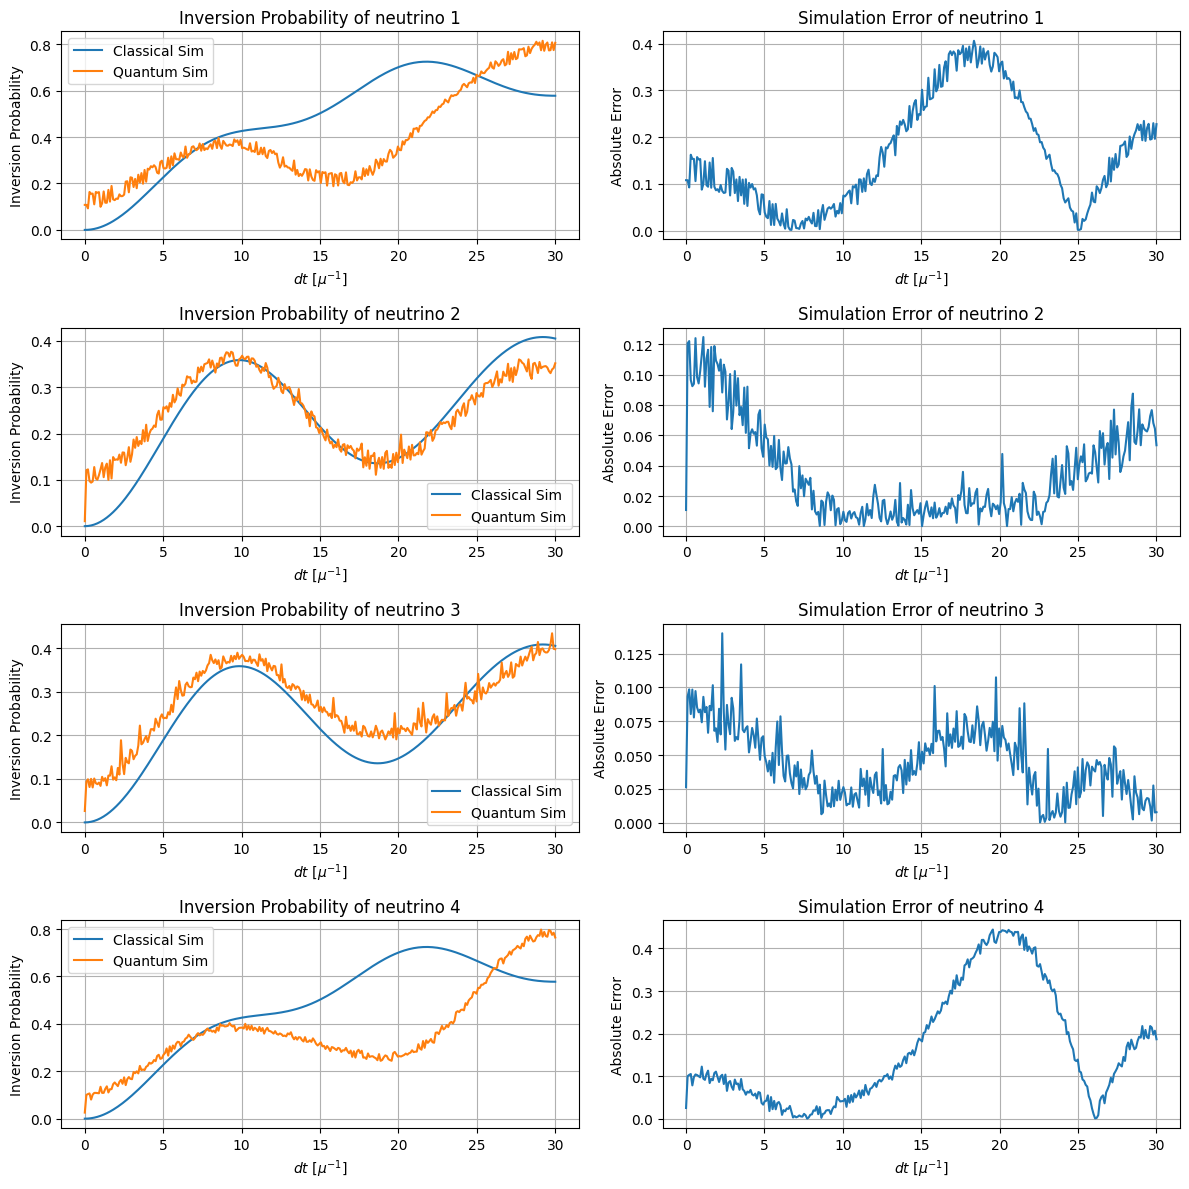

Circuit Depth: 235


In [105]:
fig, axs = plt.subplots(N, 2, figsize=(12, 12))
for qubit in range(N):
    axs[qubit, 0].plot(classical_times, classical_probabilities[qubit], label=f'Classical Sim')
    axs[qubit, 0].plot(times, fractal_probabilities[qubit], label=f'Quantum Sim')
    error = np.abs(classical_probabilities[qubit] - fractal_probabilities[qubit])
    axs[qubit, 1].plot(times, error, label=f'Error')

    axs[qubit, 0].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit, 0].set_ylabel('Inversion Probability')
    axs[qubit, 0].set_title(f'Inversion Probability of neutrino {qubit+1}')
    axs[qubit, 0].legend()
    axs[qubit, 0].grid(True)
    
    axs[qubit, 1].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit, 1].set_ylabel('Absolute Error')
    axs[qubit, 1].set_title(f'Simulation Error of neutrino {qubit+1}')
    axs[qubit, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"Circuit Depth: {max(depths)}")

### Fractal decomposition (double, order 2)

The one-body and interaction terms can be split using Fractal decomposition, and the interaction Hamiltonian can be approximated by applying fractal decomposition again. $e^{-itH}\approx e^{-it\frac{H_1}{2}} (\prod_{i=1}^n \prod_{j>i}^n e^{-itH_2^{ij}}) (\prod_{i=n}^1 \prod_{j>i}^{i+1} e^{-it\frac{H_1}{2}}) e^{-it\frac {H_1} 2}$ where $H_2^{ij} = \frac{(1 - \cos\phi_{ij})}{N} \underline \sigma_i \cdot \underline \sigma_j$

In [106]:
double_fractal_probabilities = np.zeros((N, steps))
depths = []

for t_idx, t in enumerate(times): 
    circuit = QuantumCircuit(N)
    circuit.initialize("".join(map(str, reversed(initial_flavors))))
    mRy, Rz, Ry = OneBodyGate(t/2, Ham.b1, Ham.b3)
    
    for i in range(N):
        circuit.append(mRy, [i])
        circuit.append(Rz, [i])
        circuit.append(Ry, [i])
        
    for i in range(N):
        for j in range(i+1,N):
            if not (i == N-2 and j == N-1):
                H = HamiltonianGate(Ham.interactionQObj(i,j).data.toarray(), t/2, label=f'InteractionHamiltonian {i},{j}')
                circuit.append(H, [i,j])
                  
    H = HamiltonianGate(Ham.interactionQObj(N-2,N-1).data.toarray(), t, label=f'InteractionHamiltonian {N-2},{N-1}')
    circuit.append(H, [N-2,N-1])  
            
    for i in reversed(range(N)):
        for j in reversed(range(i+1,N)):
            if not (i == N-2 and j == N-1):
                H = HamiltonianGate(Ham.interactionQObj(i,j).data.toarray(), t/2, label=f'InteractionHamiltonian {i},{j}')
                circuit.append(H, [i,j])

    for i in range(N):
        circuit.append(mRy, [i])
        circuit.append(Rz, [i])
        circuit.append(Ry, [i])
            
    circuit.measure_all()
        
    circ = transpile(circuit, backend)
    
    depths.append(circ.depth())
        
    result = qiskit.execute(circ, backend, shots=shots).result()
    counts = result.get_counts()
    
    bit_frequencies = [0 for i in range(N)] # A counter for how many times each qubit flips
    outcomes = []
    
    for bitstring, frequency in counts.items():
        bit_list = list(map(int, bitstring))
        bit_list = np.array(list(reversed(bit_list))) # Reverse because little-endian?
        for i in range(frequency):
            inversions = (bit_list + initial_flavors) % 2 # 1 if inverted, 0 if not
            outcomes.append(inversions)
    outcomes = np.array(outcomes)
    assert outcomes.shape == (shots, N)
    
    probability = outcomes.mean(axis=0)
    assert len(probability) == N
    double_fractal_probabilities[:, t_idx] = probability

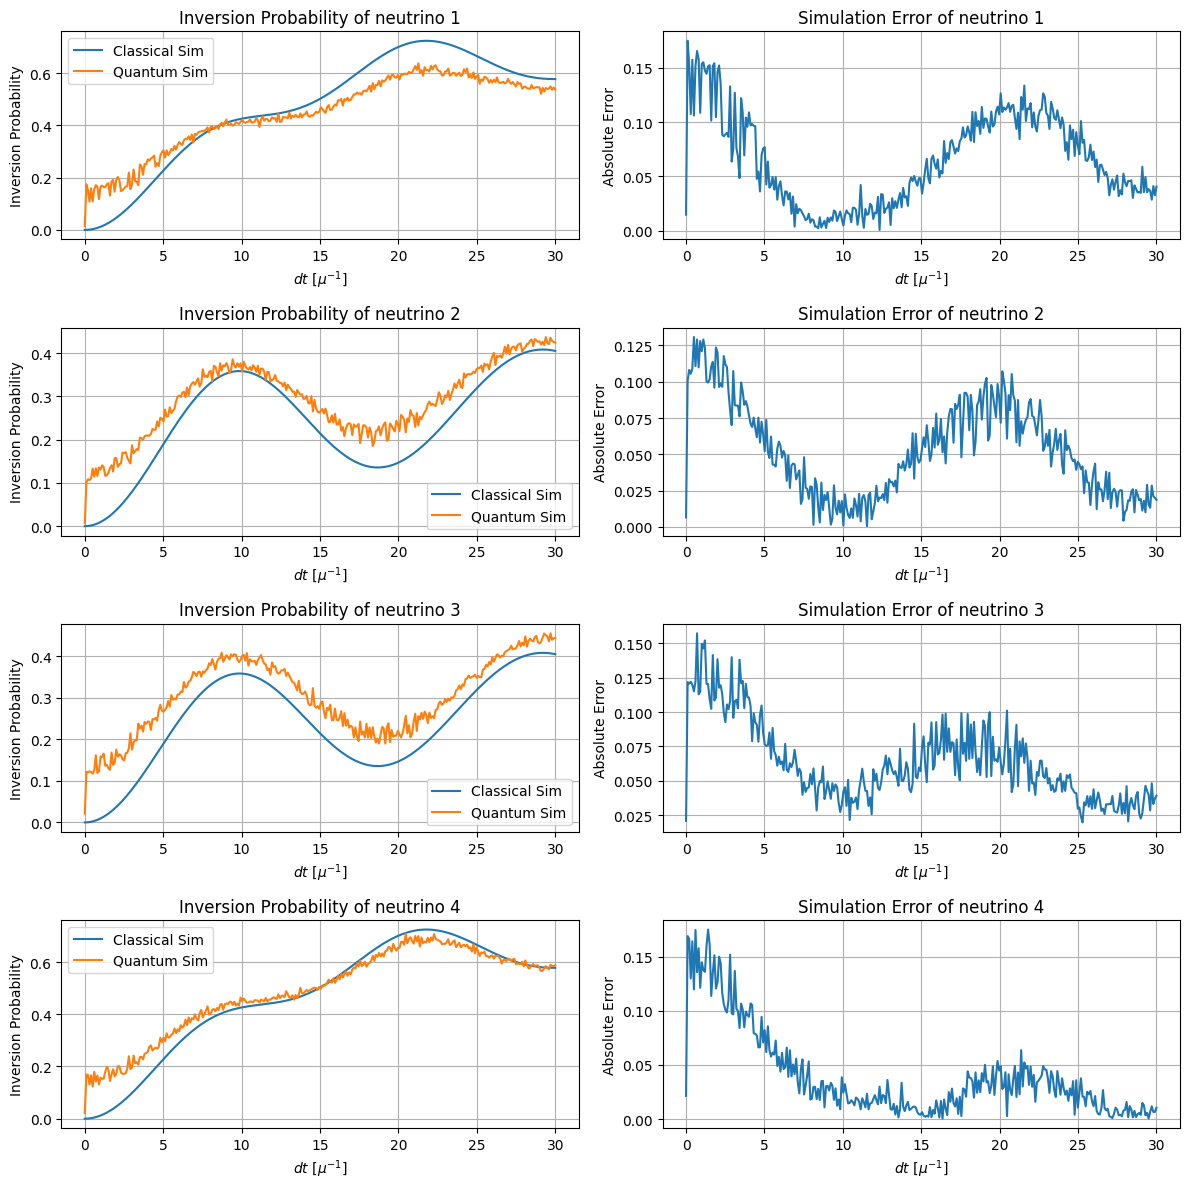

Circuit Depth: 229


In [107]:
fig, axs = plt.subplots(N, 2, figsize=(12, 12))
for qubit in range(N):
    axs[qubit, 0].plot(classical_times, classical_probabilities[qubit], label=f'Classical Sim')
    axs[qubit, 0].plot(times, double_fractal_probabilities[qubit], label=f'Quantum Sim')
    error = np.abs(classical_probabilities[qubit] - double_fractal_probabilities[qubit])
    axs[qubit, 1].plot(times, error, label=f'Error')

    axs[qubit, 0].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit, 0].set_ylabel('Inversion Probability')
    axs[qubit, 0].set_title(f'Inversion Probability of neutrino {qubit+1}')
    axs[qubit, 0].legend()
    axs[qubit, 0].grid(True)
    
    axs[qubit, 1].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit, 1].set_ylabel('Absolute Error')
    axs[qubit, 1].set_title(f'Simulation Error of neutrino {qubit+1}')
    axs[qubit, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"Circuit Depth: {max(depths)}")

## Comparisions

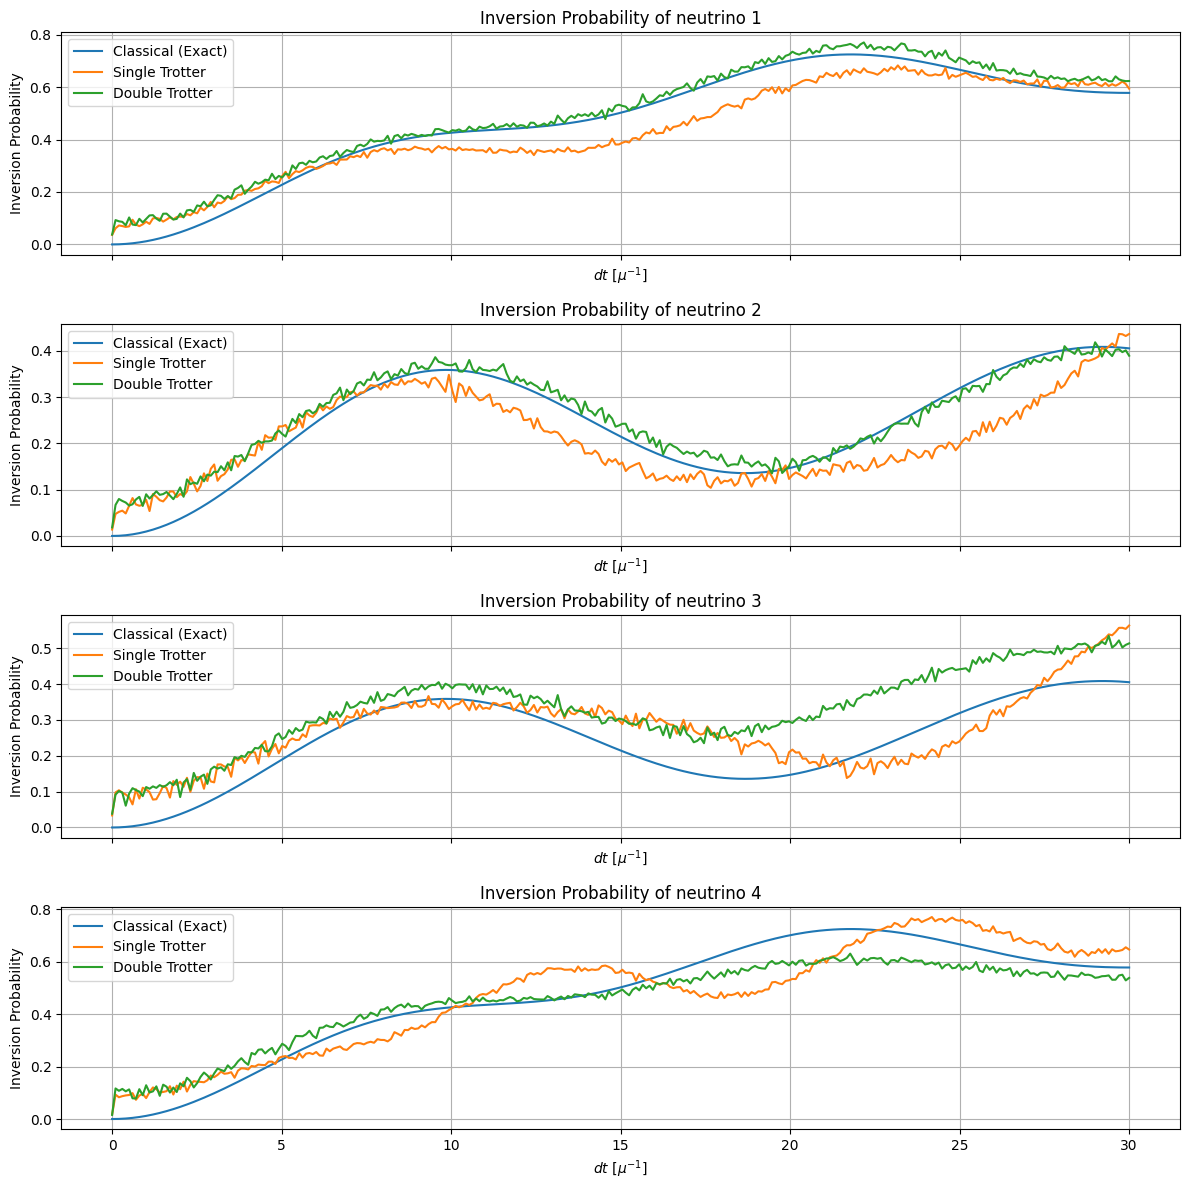

In [110]:
fig, axs = plt.subplots(N, figsize=(12, 12), sharex=True)
for qubit in range(N):
    axs[qubit].plot(classical_times, classical_probabilities[qubit], label=f'Classical (Exact)')
    axs[qubit].plot(times, single_trotter_probabilities[qubit], label=f'Single Trotter')
    axs[qubit].plot(times, double_trotter_probabilities[qubit], label=f'Double Trotter')
    #axs[qubit].plot(times, fractal_probabilities[qubit], label=f'Single Fractal')
    #axs[qubit].plot(times, double_fractal_probabilities[qubit], label=f'Double Fractal')

    axs[qubit].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit].set_ylabel('Inversion Probability')
    axs[qubit].set_title(f'Inversion Probability of neutrino {qubit+1}')
    axs[qubit].legend()
    axs[qubit].grid(True)

plt.tight_layout()
plt.show()

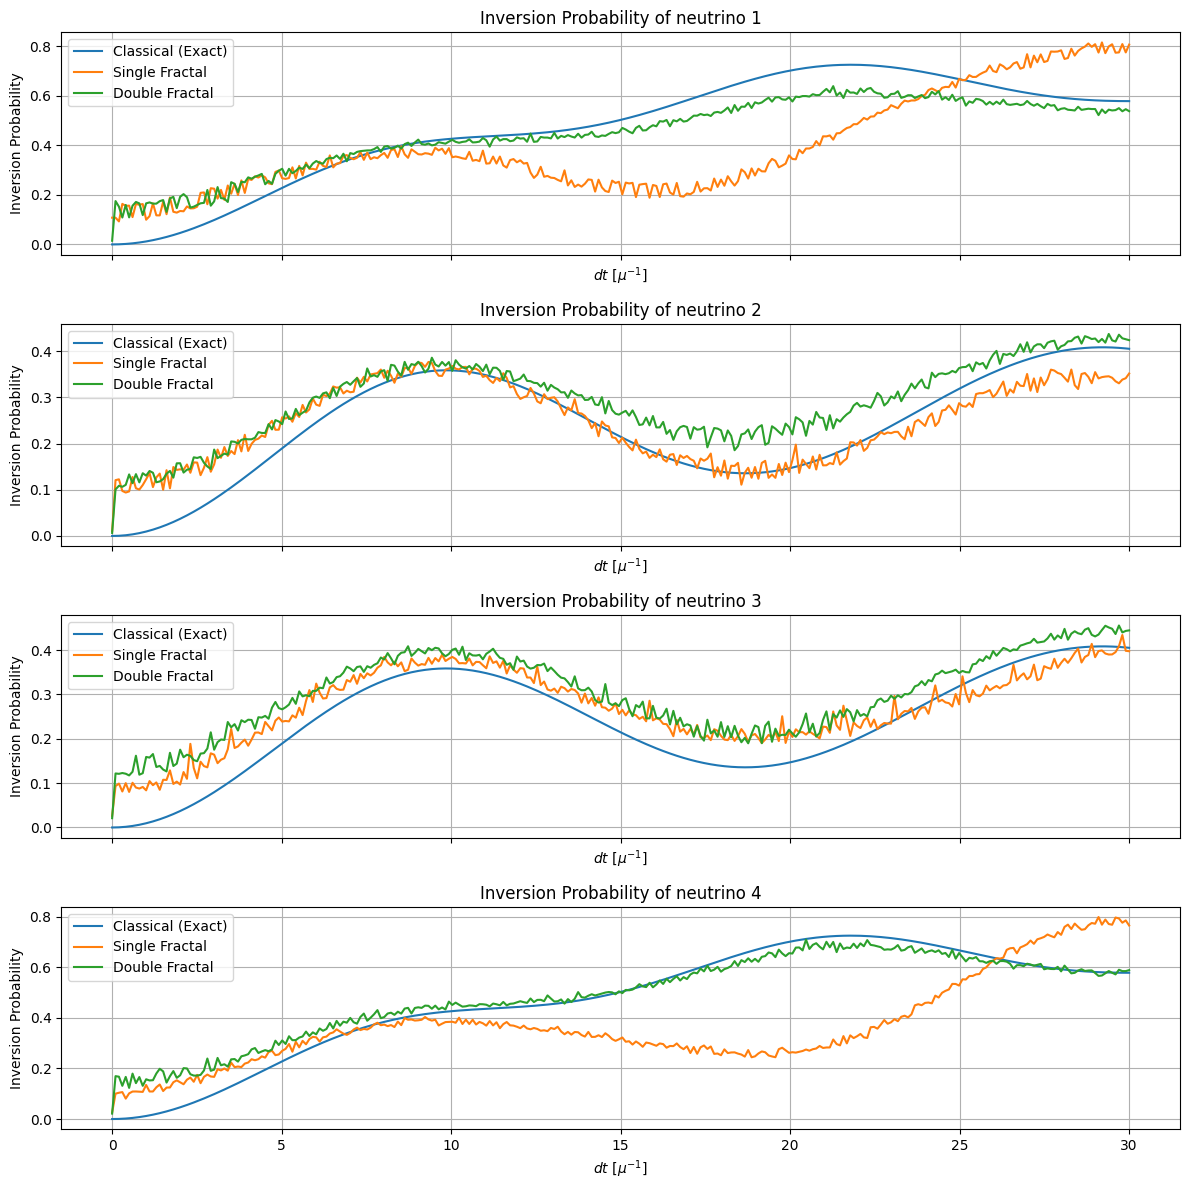

In [114]:
fig, axs = plt.subplots(N, figsize=(12, 12), sharex=True)
for qubit in range(N):
    axs[qubit].plot(classical_times, classical_probabilities[qubit], label=f'Classical (Exact)')
    #axs[qubit].plot(times, single_trotter_probabilities[qubit], label=f'Single Trotter')
    #axs[qubit].plot(times, double_trotter_probabilities[qubit], label=f'Double Trotter')
    axs[qubit].plot(times, fractal_probabilities[qubit], label=f'Single Fractal')
    axs[qubit].plot(times, double_fractal_probabilities[qubit], label=f'Double Fractal')

    axs[qubit].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit].set_ylabel('Inversion Probability')
    axs[qubit].set_title(f'Inversion Probability of neutrino {qubit+1}')
    axs[qubit].legend()
    axs[qubit].grid(True)

plt.tight_layout()
plt.show()


## Old Comparisions, Short coherence time

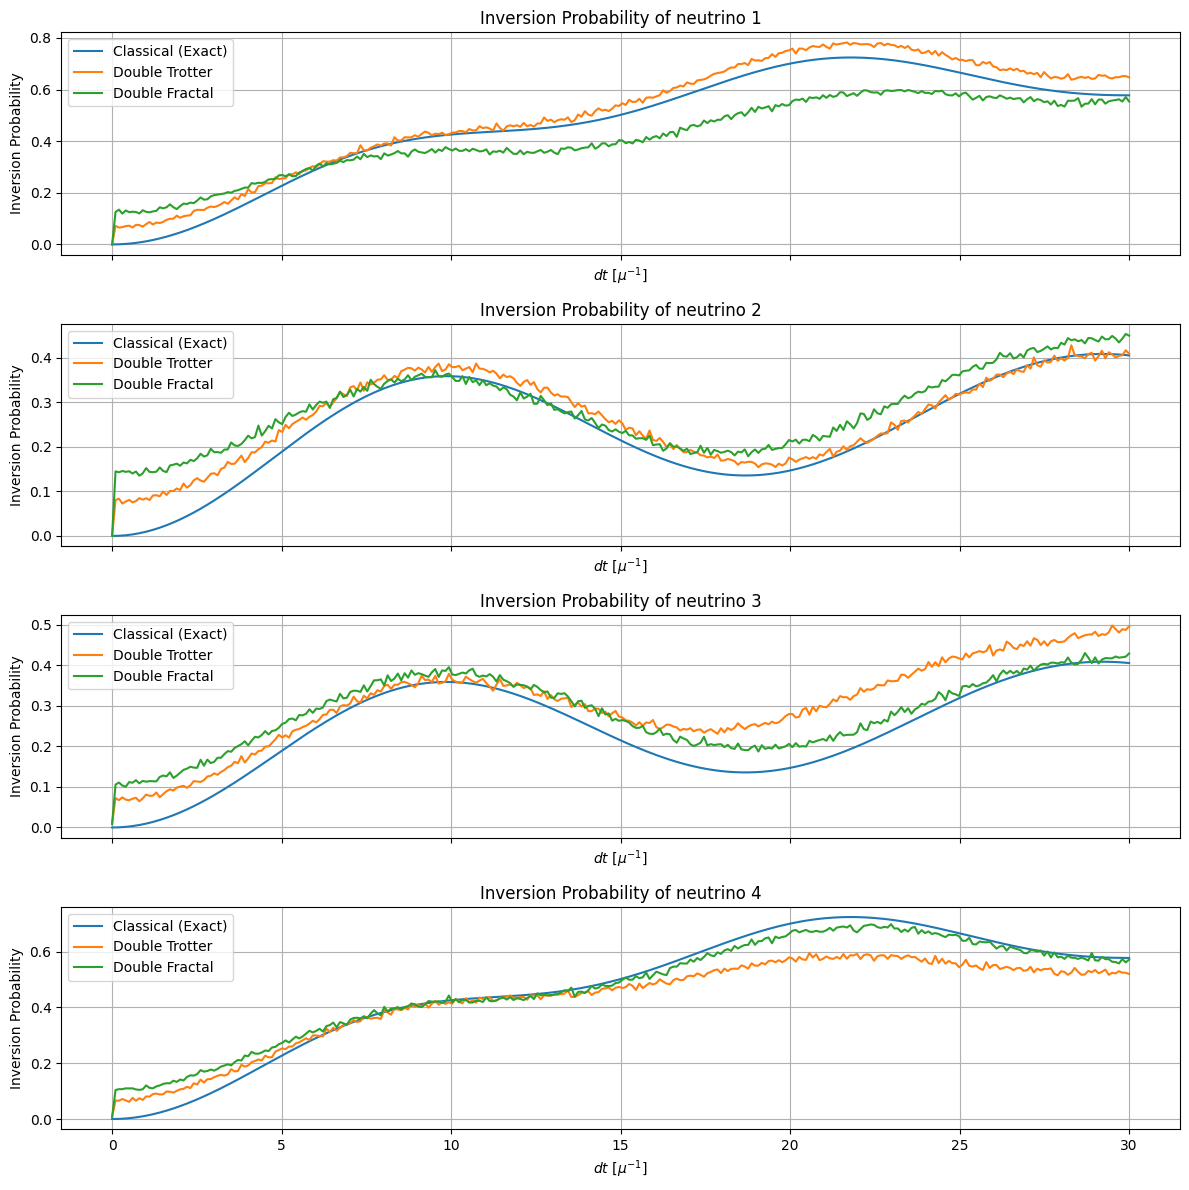

In [96]:
fig, axs = plt.subplots(N, figsize=(12, 12), sharex=True)
for qubit in range(N):
    axs[qubit].plot(classical_times, classical_probabilities[qubit], label=f'Classical (Exact)')
    #axs[qubit].plot(times, single_trotter_probabilities[qubit], label=f'Single Trotter')
    axs[qubit].plot(times, double_trotter_probabilities[qubit], label=f'Double Trotter')
    #axs[qubit].plot(times, fractal_probabilities[qubit], label=f'Single Fractal')
    axs[qubit].plot(times, double_fractal_probabilities[qubit], label=f'Double Fractal')

    axs[qubit].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit].set_ylabel('Inversion Probability')
    axs[qubit].set_title(f'Inversion Probability of neutrino {qubit+1}')
    axs[qubit].legend()
    axs[qubit].grid(True)

plt.tight_layout()
plt.show()

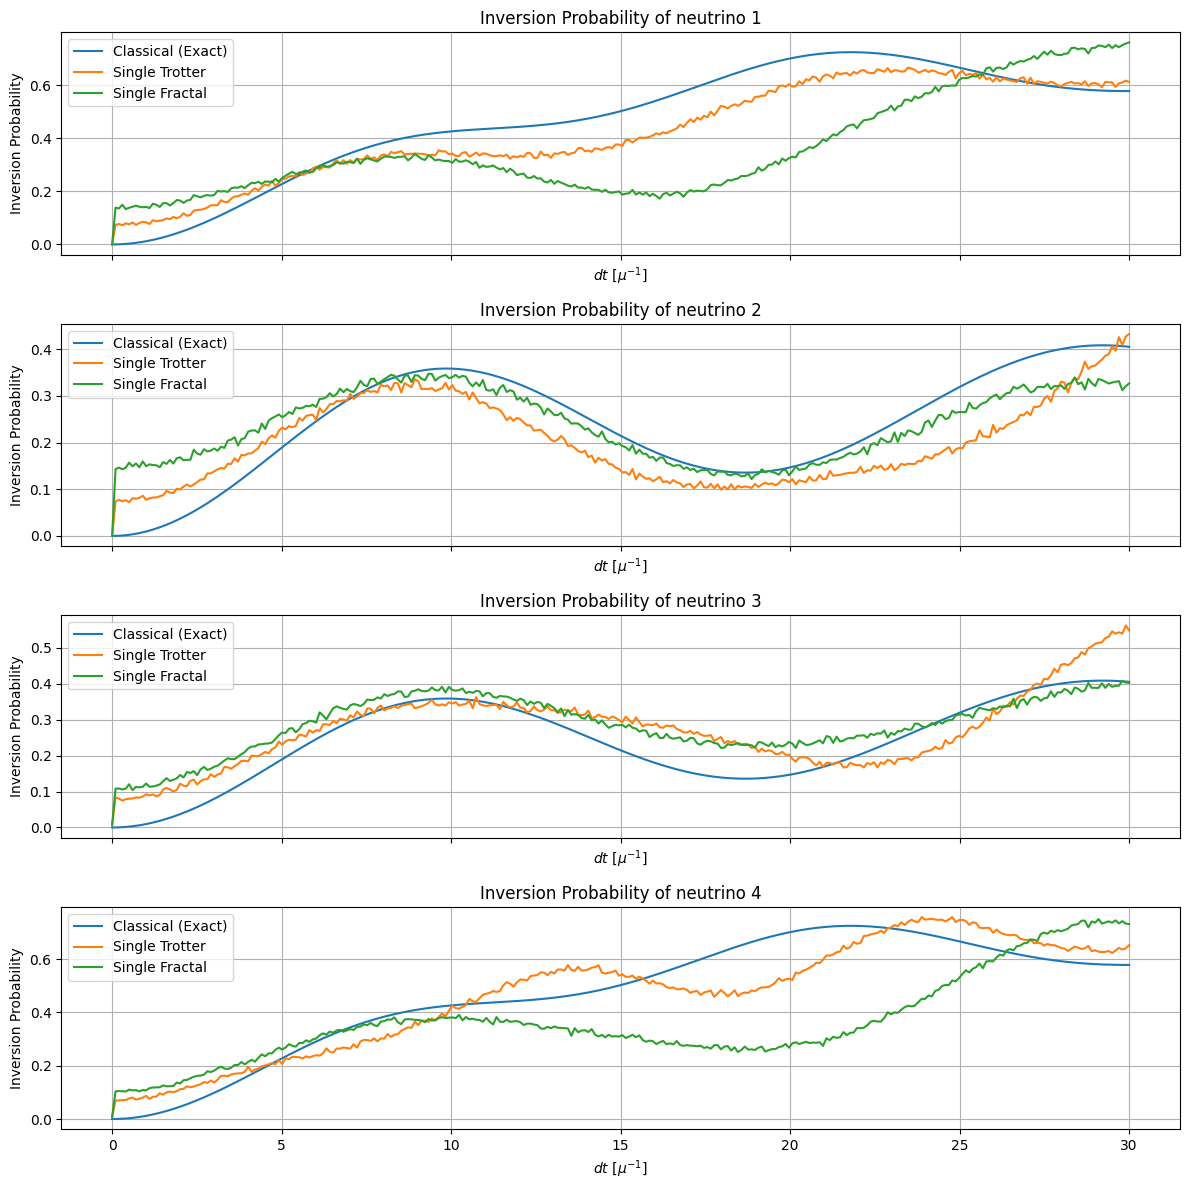

In [95]:
fig, axs = plt.subplots(N, figsize=(12, 12), sharex=True)
for qubit in range(N):
    axs[qubit].plot(classical_times, classical_probabilities[qubit], label=f'Classical (Exact)')
    axs[qubit].plot(times, single_trotter_probabilities[qubit], label=f'Single Trotter')
    #axs[qubit].plot(times, double_trotter_probabilities[qubit], label=f'Double Trotter')
    axs[qubit].plot(times, fractal_probabilities[qubit], label=f'Single Fractal')
    #axs[qubit].plot(times, double_fractal_probabilities[qubit], label=f'Double Fractal')

    axs[qubit].set_xlabel('$dt$ [$\mu^{-1}$]')
    axs[qubit].set_ylabel('Inversion Probability')
    axs[qubit].set_title(f'Inversion Probability of neutrino {qubit+1}')
    axs[qubit].legend()
    axs[qubit].grid(True)

plt.tight_layout()
plt.show()
